##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

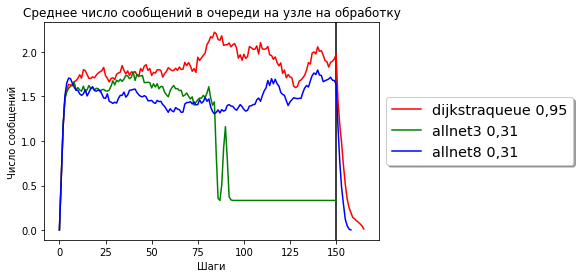

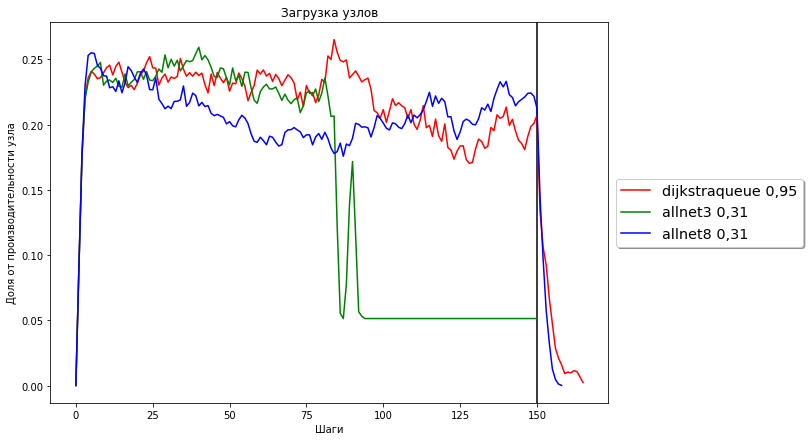

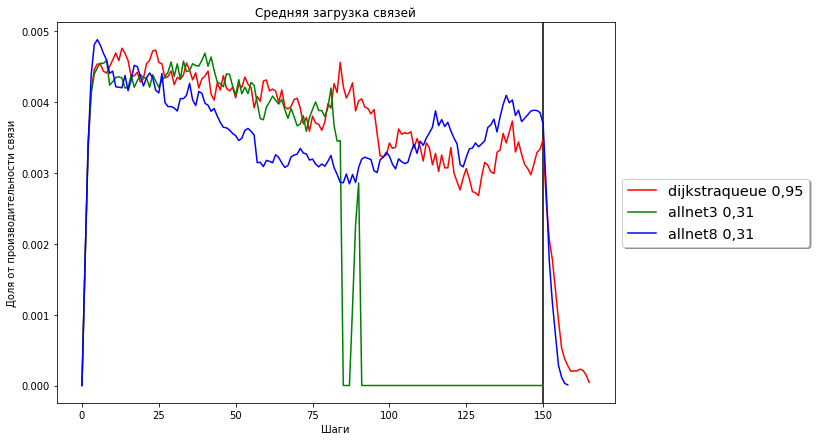

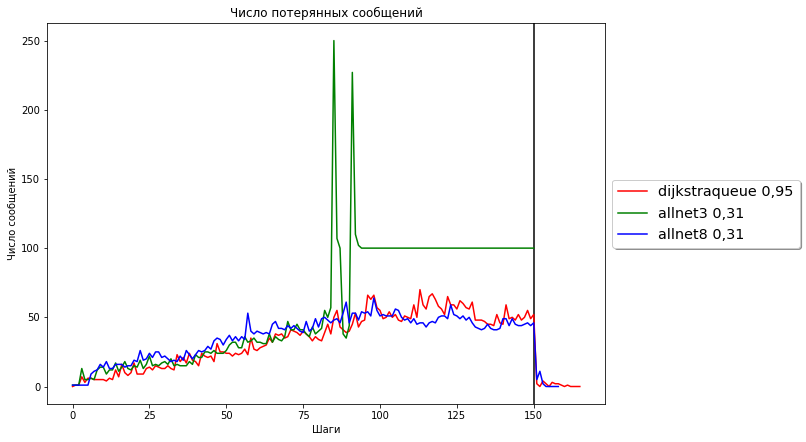

Доставлено 9714 Потеряно 35.2443% -dijkstraqueue 0,95
Доставлено 6228 Потеряно 58.4828% -allnet3 0,31
Доставлено 9409 Потеряно 37.2775% -allnet8 0,31


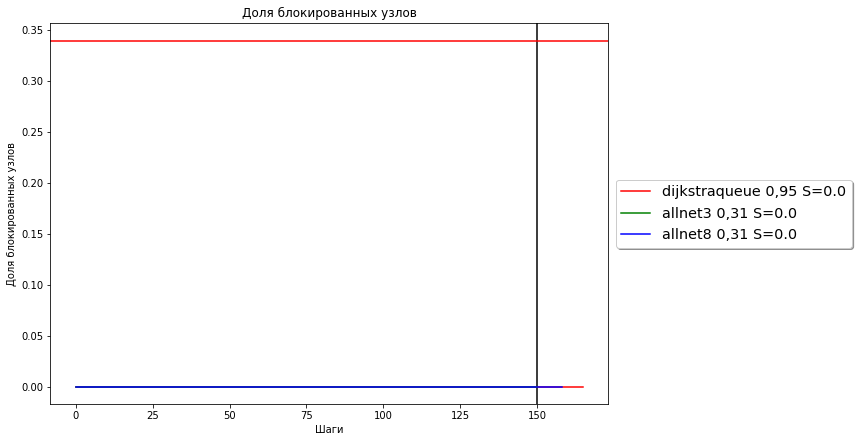

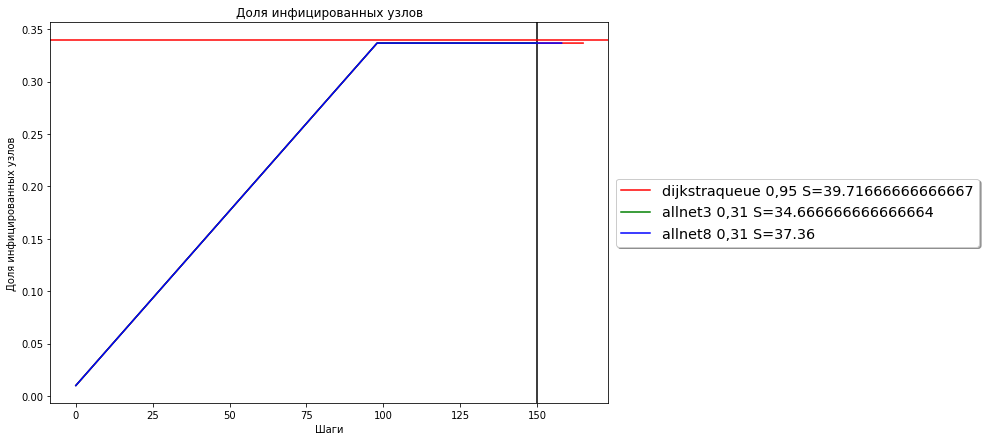

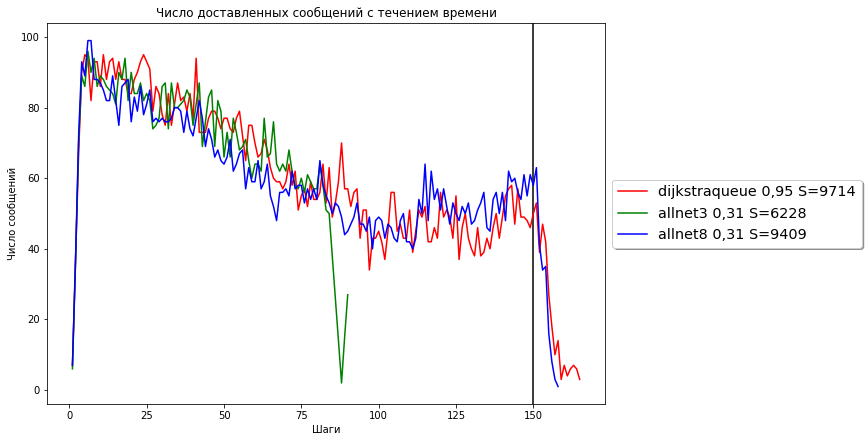

In [2]:
quantity = 100;
log_tags = [
{"tag":  "cc41cd08-d508-4c64-b5aa-8738688ce2e6", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ab385b99-d22d-411b-860b-fa39ea0a0260", "label": "allnet3 0,31", "color": "green"},
{"tag":  "7ab8710a-de5a-4e73-a592-fb5b78a5a858", "label": "allnet8 0,31", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

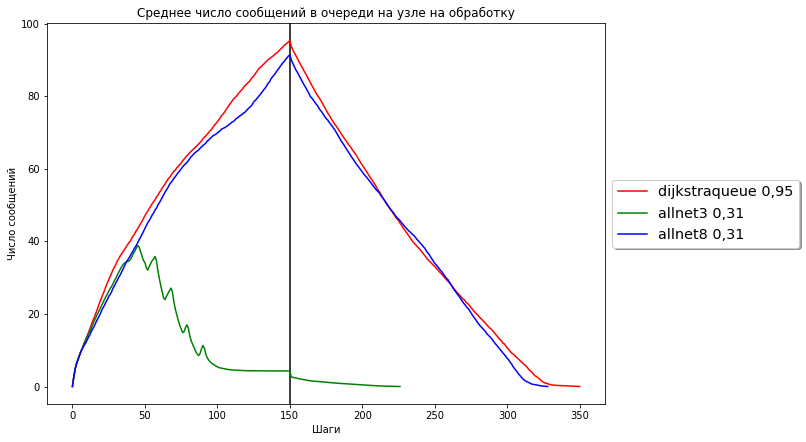

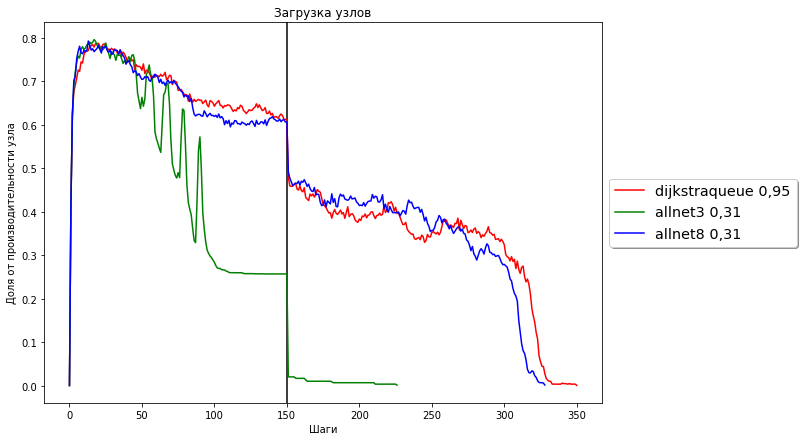

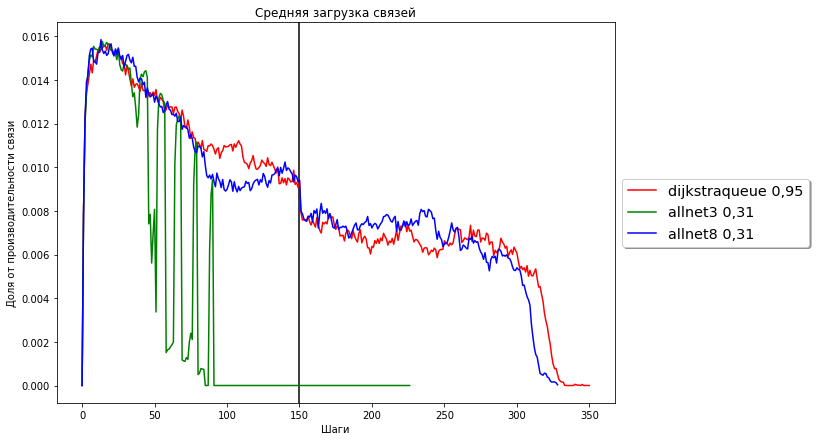

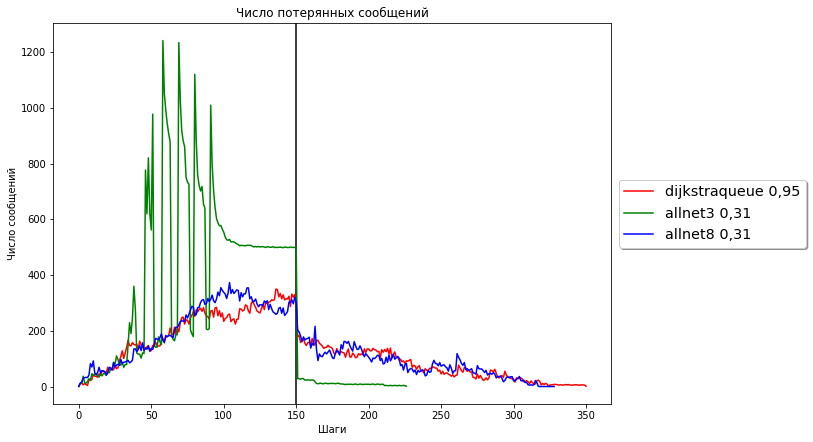

Доставлено 30797 Потеряно 58.9379% -dijkstraqueue 0,95
Доставлено 11753 Потеряно 84.3295% -allnet3 0,31
Доставлено 29132 Потеряно 61.1579% -allnet8 0,31


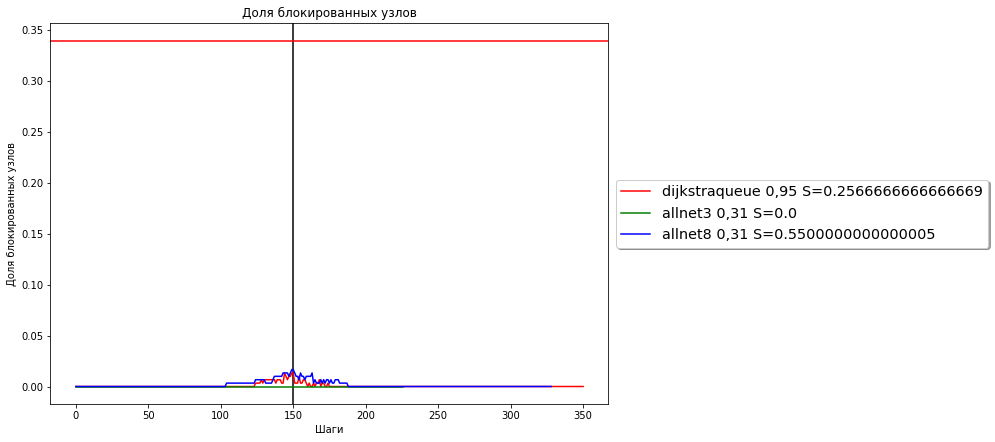

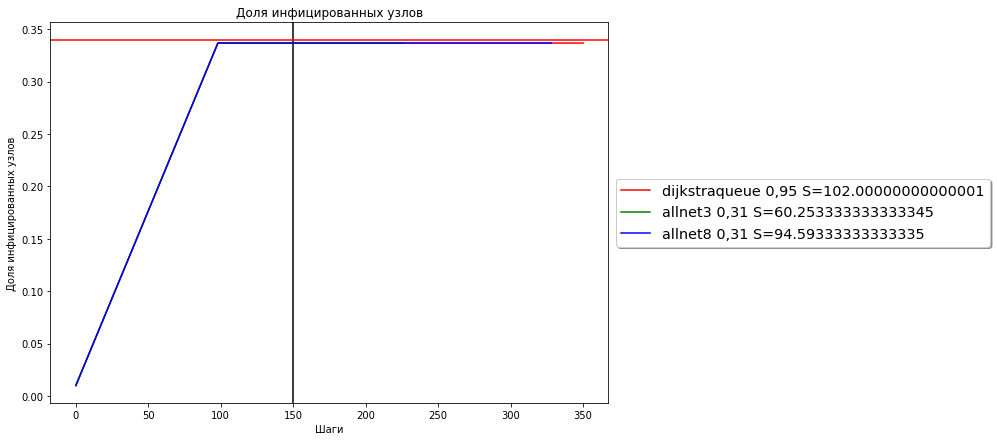

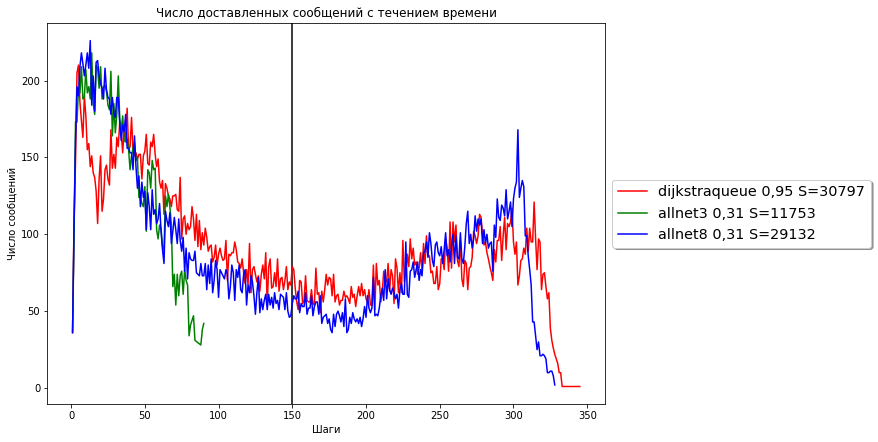

In [3]:
quantity = 500;
log_tags = [
{"tag":  "37078a94-89e8-46b0-afa4-2c205da72a7e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "3bcfbd3c-c33c-427b-9f3f-2de5ae7fe297", "label": "allnet3 0,31", "color": "green"},
{"tag":  "c7c5a5c6-6b32-44fc-bec1-74cf21b4c205", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

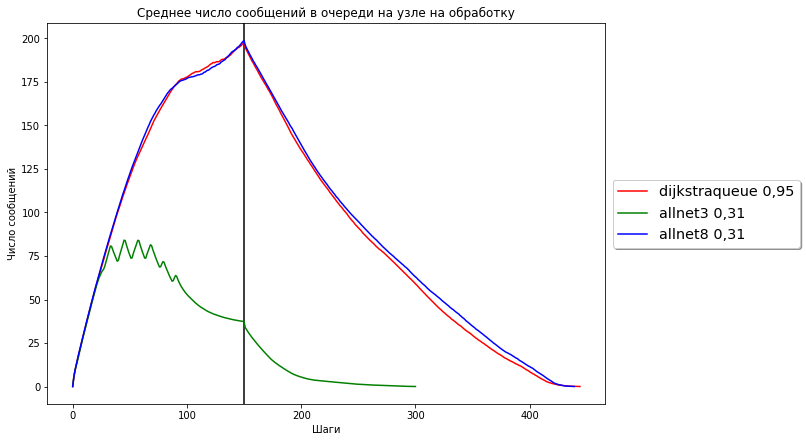

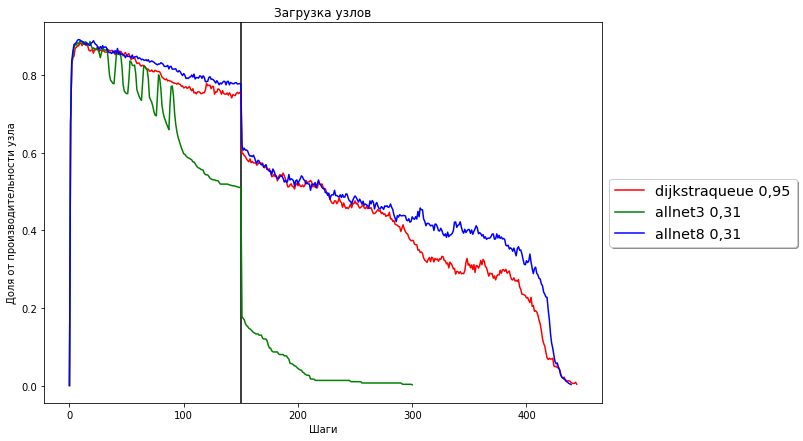

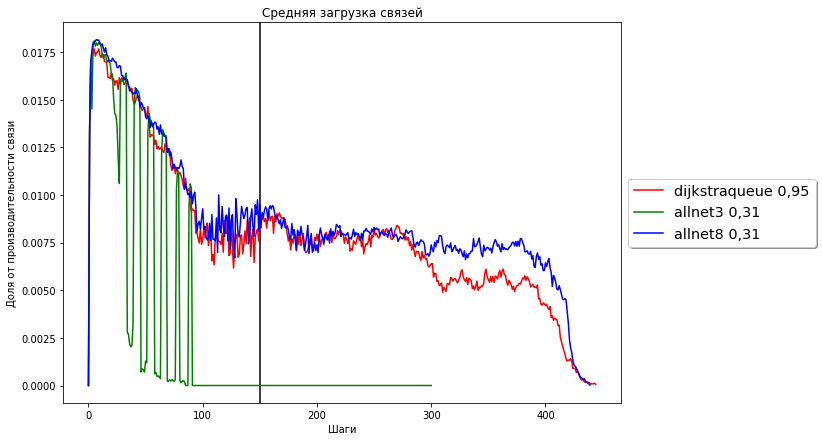

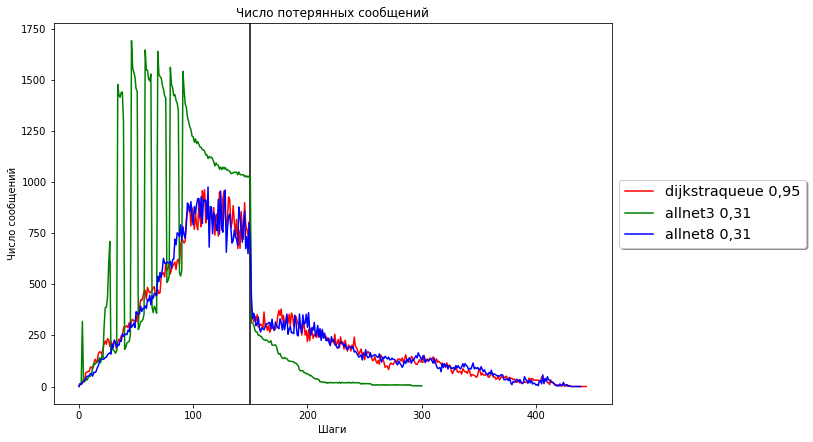

Доставлено 30541 Потеряно 79.6395% -dijkstraqueue 0,95
Доставлено 7465 Потеряно 95.0234% -allnet3 0,31
Доставлено 31257 Потеряно 79.1621% -allnet8 0,31


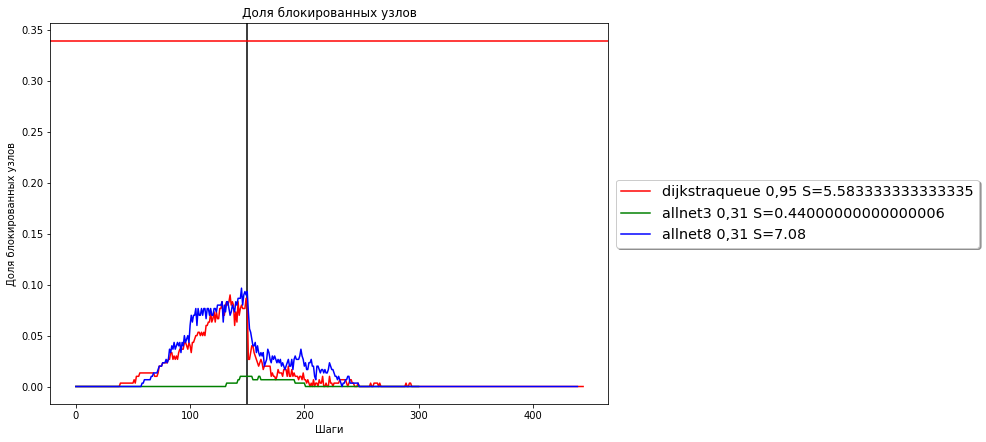

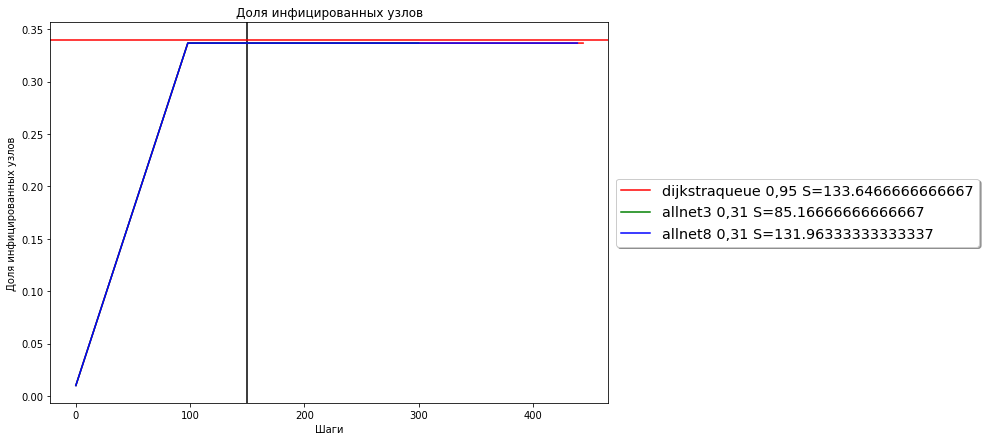

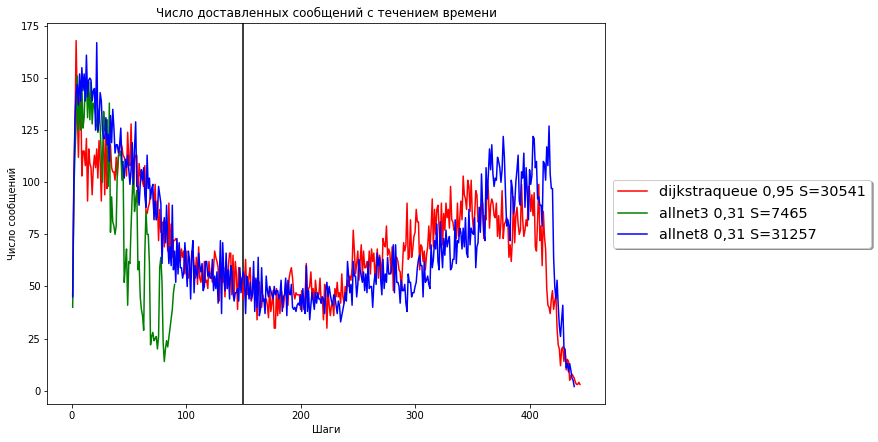

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "7f751b5b-21cc-4cf8-bf94-8919b7b095e5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f187a54c-d03e-4f18-89bf-30fe6be5b078", "label": "allnet3 0,31", "color": "green"},
{"tag":  "386b2281-b42c-4f34-96b9-bc91fc02aa0d", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

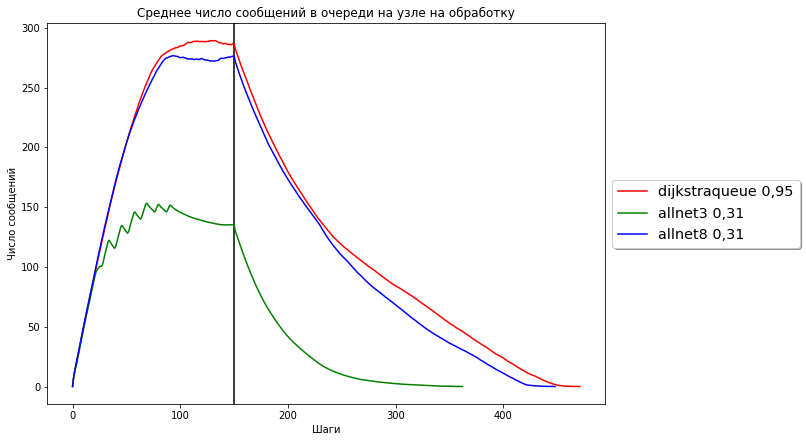

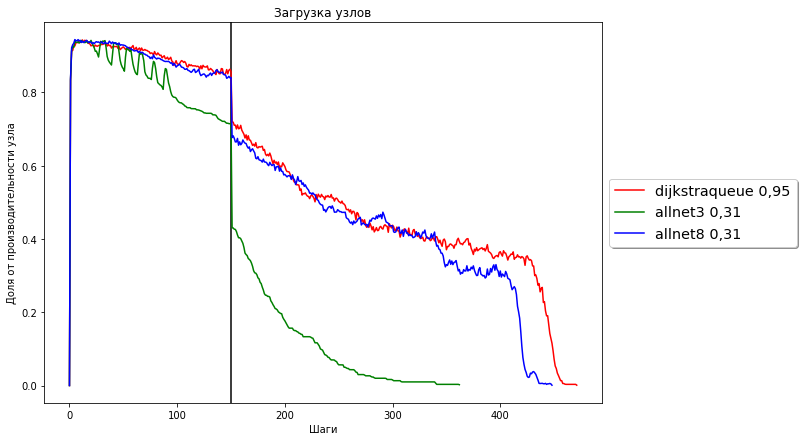

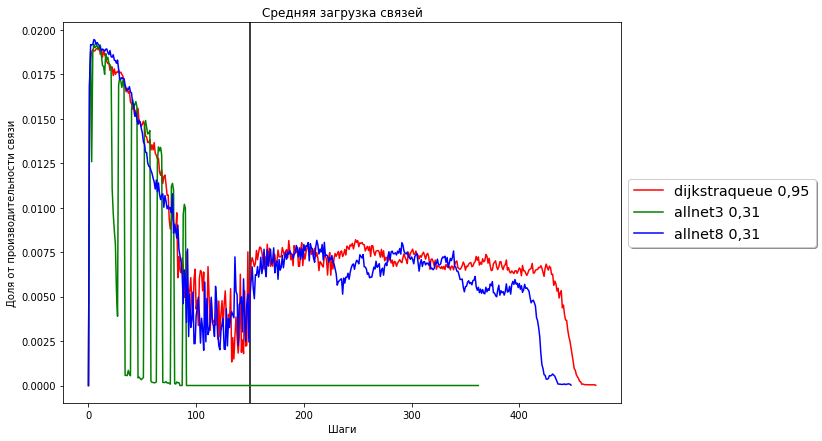

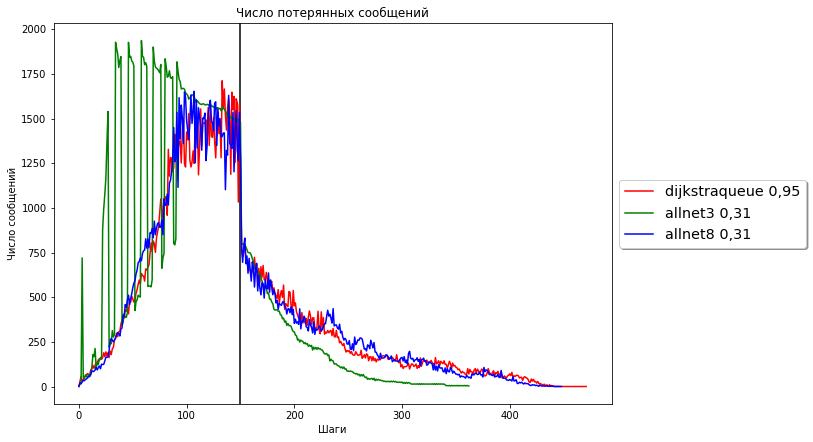

Доставлено 29135 Потеряно 87.0512% -dijkstraqueue 0,95
Доставлено 5383 Потеряно 97.6076% -allnet3 0,31
Доставлено 26908 Потеряно 88.0409% -allnet8 0,31


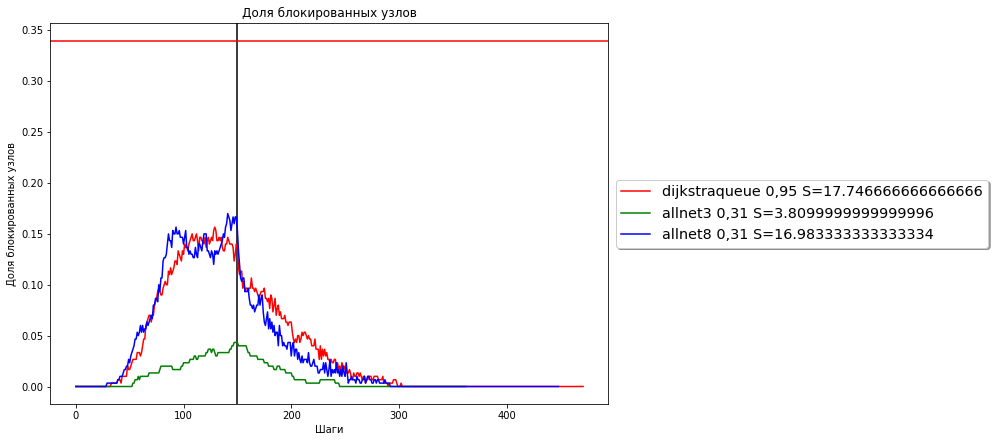

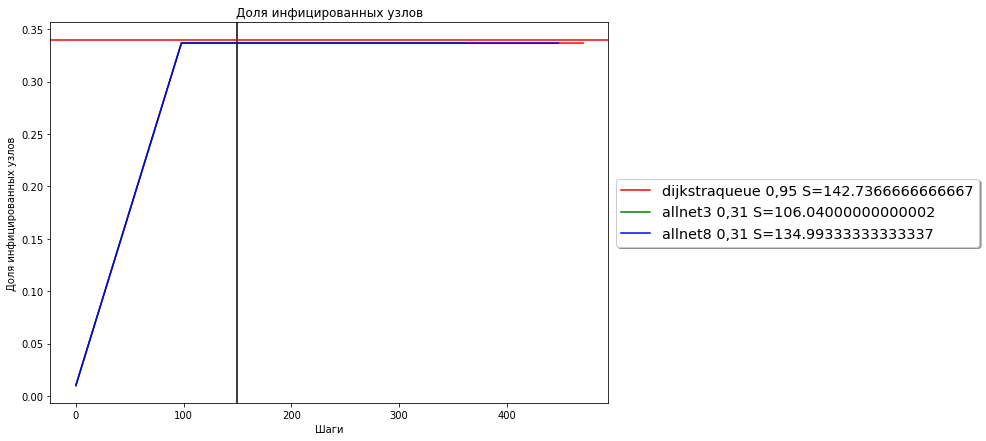

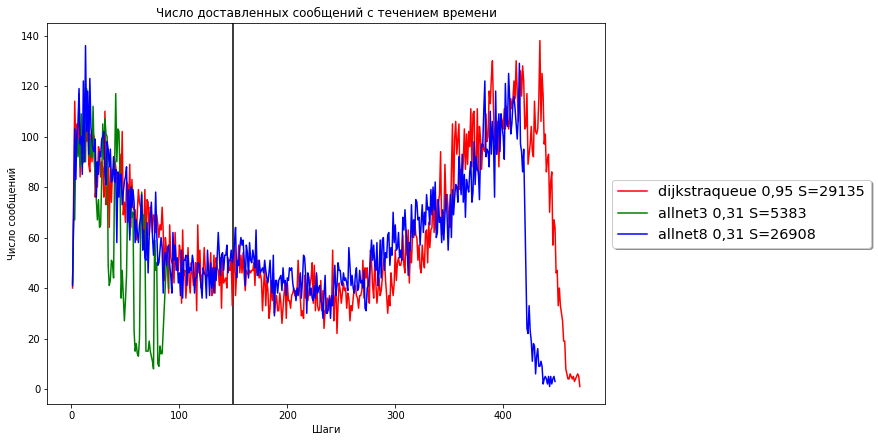

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "9220c6b1-6257-473c-a935-de022ffb5b77", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9bbcfb02-b0d7-487b-9b69-6a1a7e756112", "label": "allnet3 0,31", "color": "green"},
{"tag":  "ea3f4bca-0478-4834-93c5-0039ee63e25c", "label": "allnet8 0,31", "color": "blue"},
]

showStat()
showStatBlocked();  
showStatMessage();

Доставлено 24566 Потеряно 45.4101% -dijkstraqueue 0,95
Доставлено 14167 Потеряно 68.5185% -allnet3 0,31
Доставлено 24543 Потеряно 45.4612% -allnet8 0,31


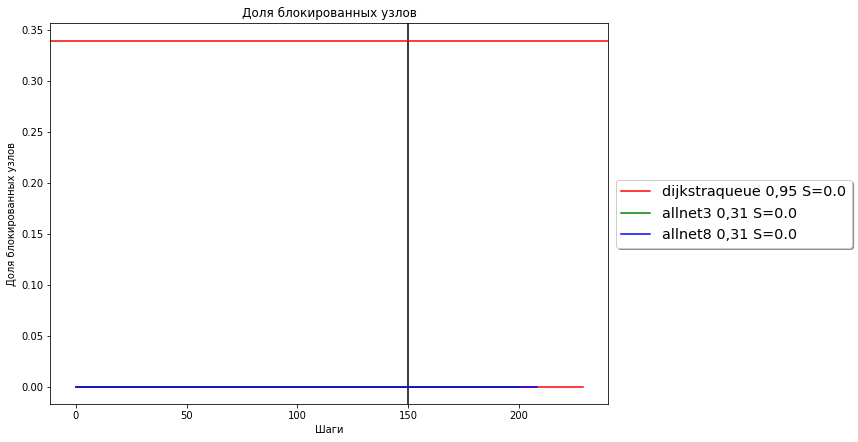

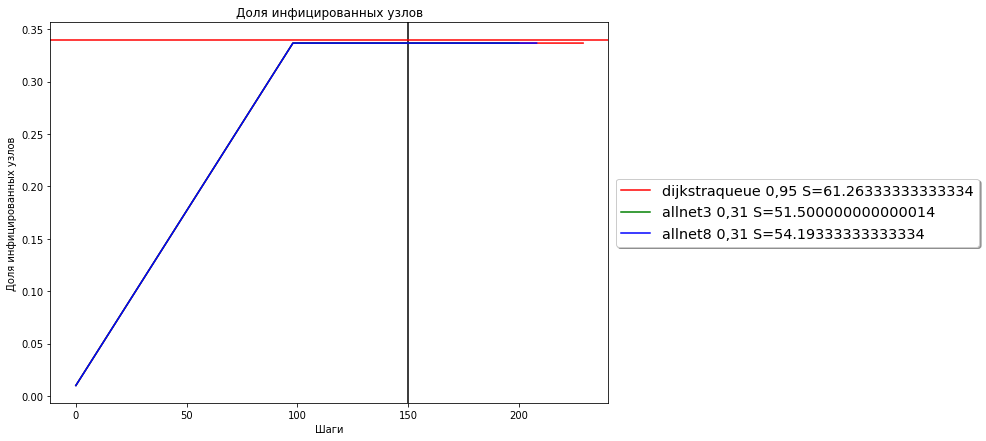

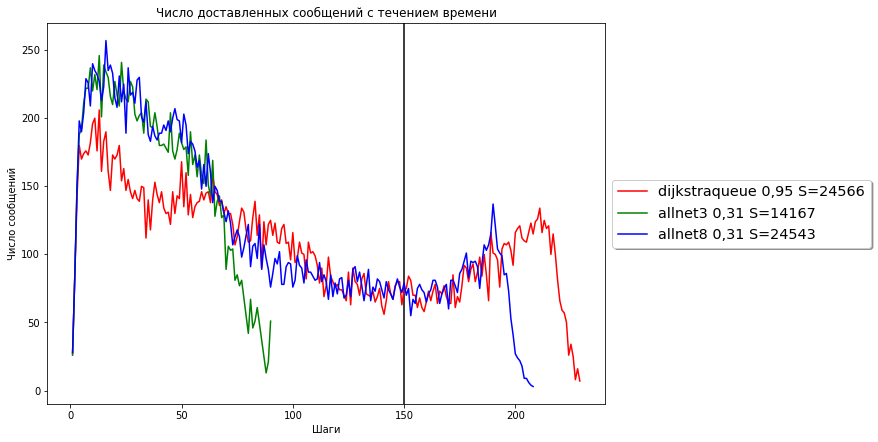

Доставлено 29634 Потеряно 71.7774% -dijkstraqueue 0,95
Доставлено 9439 Потеряно 91.0106% -allnet3 0,31
Доставлено 29379 Потеряно 72.0203% -allnet8 0,31


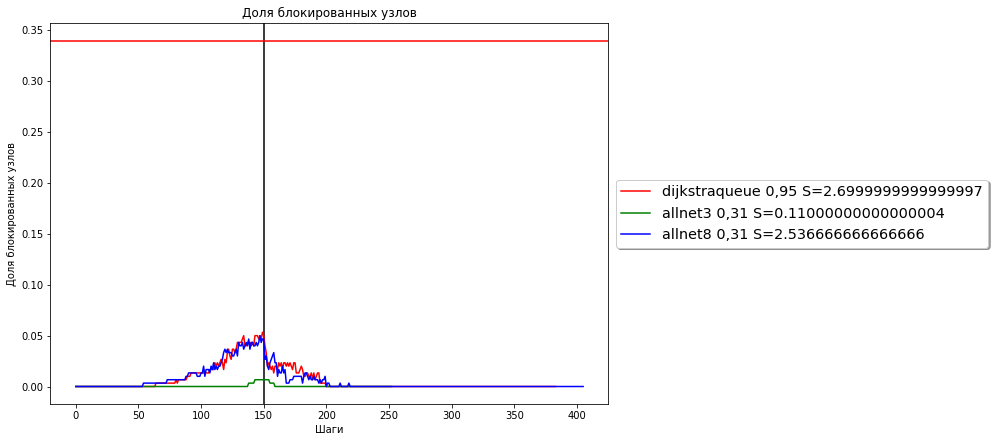

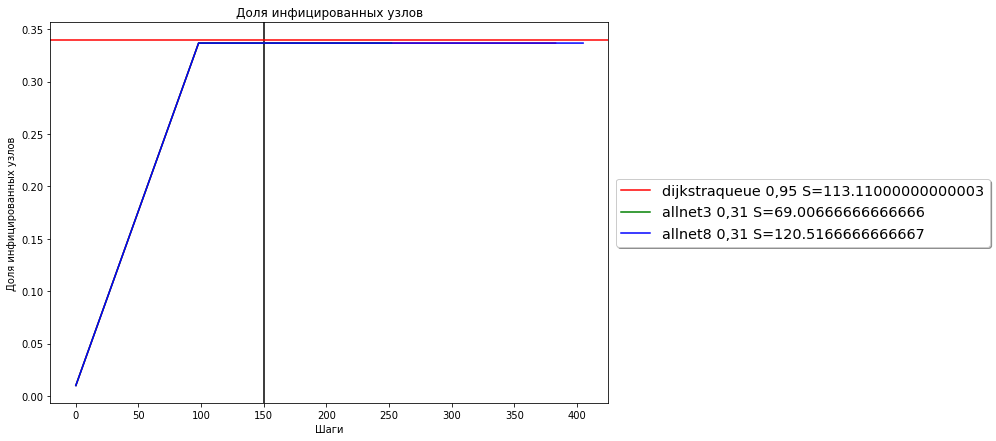

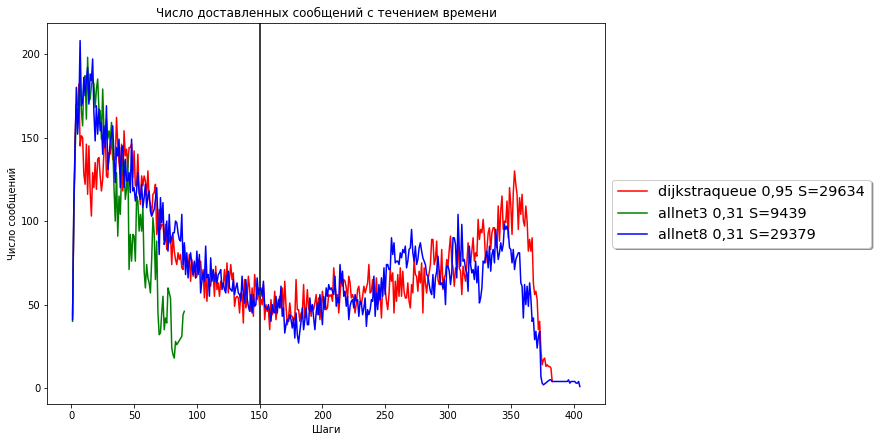

Доставлено 30035 Потеряно 77.7520% -dijkstraqueue 0,95
Доставлено 8674 Потеряно 93.5749% -allnet3 0,31
Доставлено 34796 Потеряно 74.2254% -allnet8 0,31


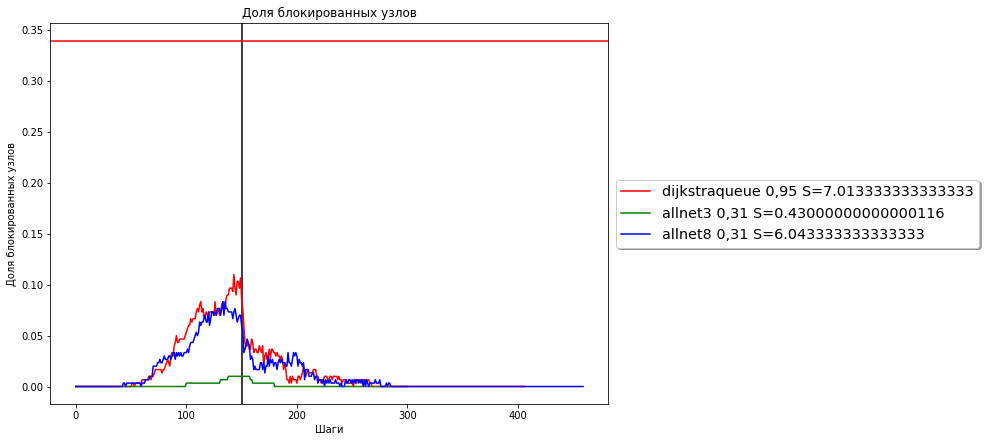

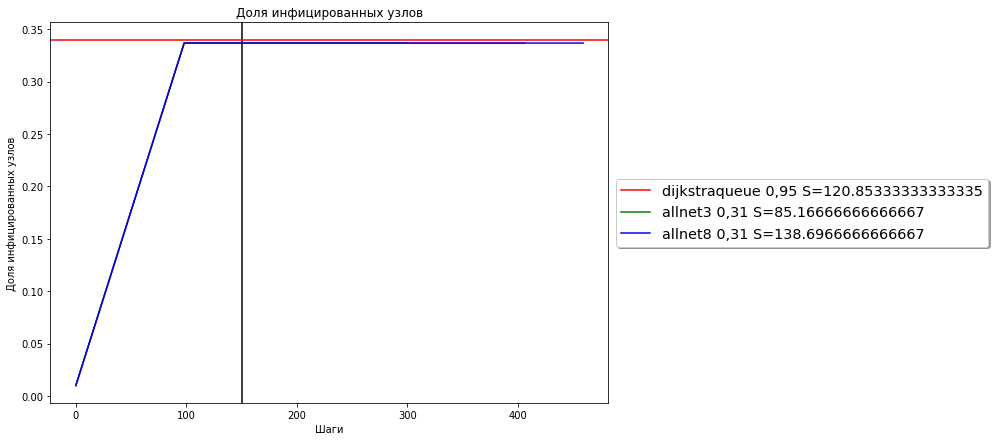

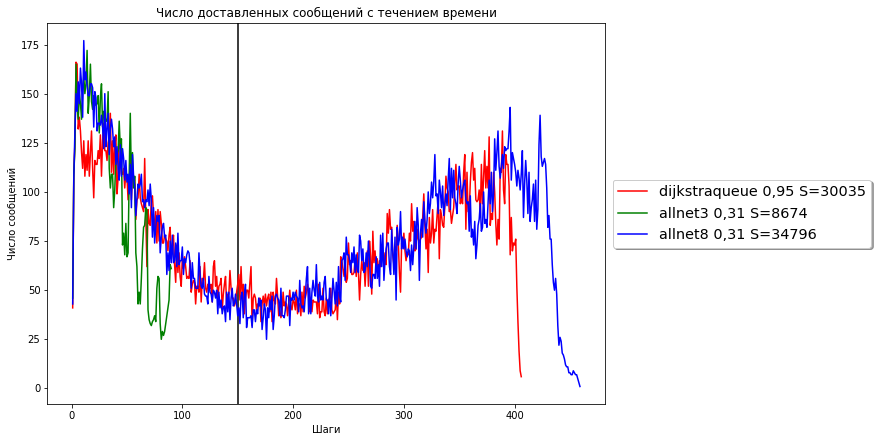

Доставлено 31371 Потеряно 83.9124% -dijkstraqueue 0,95
Доставлено 6168 Потеряно 96.8369% -allnet3 0,31
Доставлено 29650 Потеряно 84.7949% -allnet8 0,31


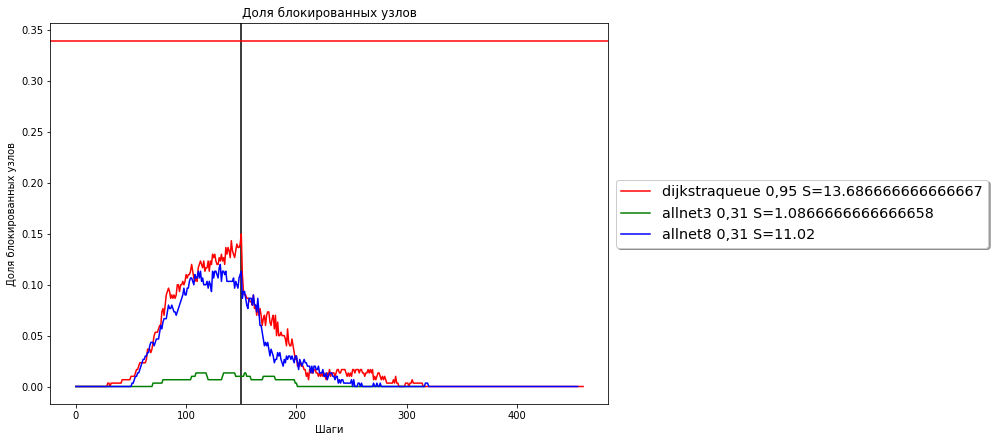

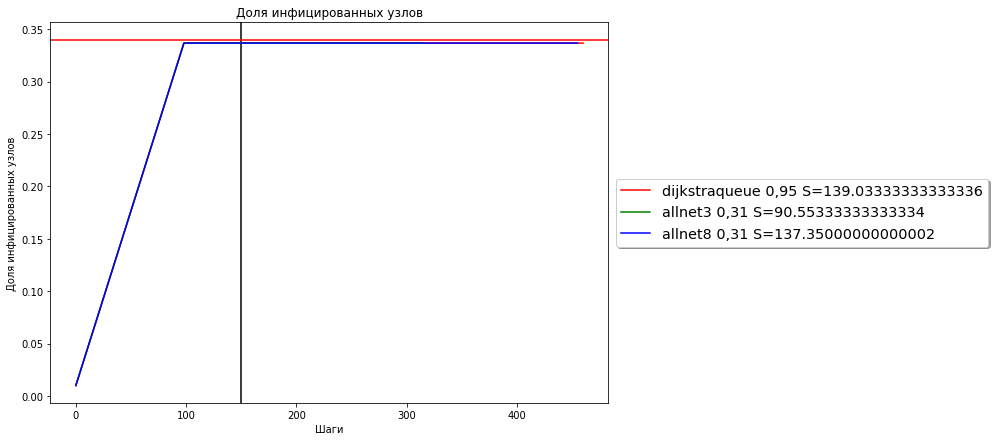

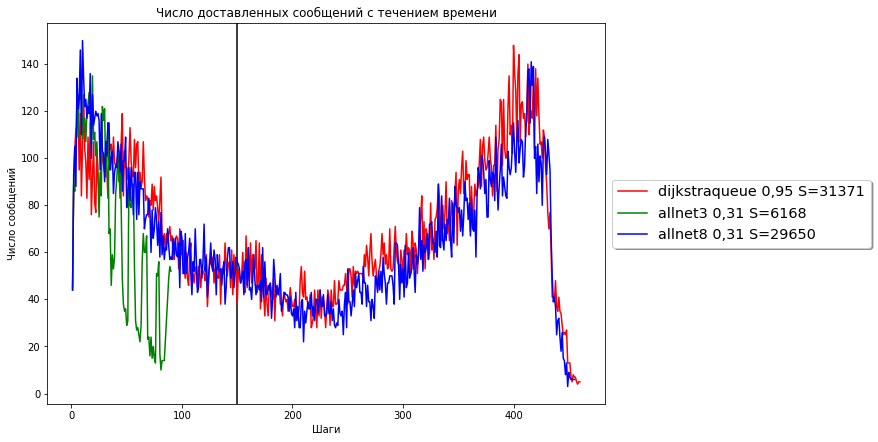

In [6]:
quantity = 300;
log_tags = [
{"tag":  "37c5d7d2-f0c7-4119-9392-5d946cfe5063", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "467e70fe-7e9f-43ac-8a3b-9f995c1c8f8f", "label": "allnet3 0,31", "color": "green"},
{"tag":  "ef5cb235-eb59-497d-ad8b-88038a60d9a4", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "639703e7-ad2e-46a1-953b-5473554be1eb", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "29655e00-e256-4cc0-ac7b-8c660b1986d5", "label": "allnet3 0,31", "color": "green"},
{"tag":  "ff754708-e7e9-4e60-a242-2a63cbb8a9ea", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "9b75ad87-925a-4134-ac02-9cc2225731d5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ce136c80-a433-447f-94eb-3b13da4a31b6", "label": "allnet3 0,31", "color": "green"},
{"tag":  "6ad0f00d-ec4e-4e68-8118-6b22919afc71", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "254e900f-e4ec-448d-a854-0a0197ce3b02", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "86a68f12-1edb-4b0c-9d76-77ae0c2dc68d", "label": "allnet3 0,31", "color": "green"},
{"tag":  "046b7efe-dec8-4732-8a56-54e188673944", "label": "allnet8 0,31", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,31  allnet8 0,31
100             3.772415      2.081261      2.886474
300            25.220795      4.768716     14.688985
500            62.448354      9.312556     59.217437
700            71.602375     13.065961     71.602290
900            81.244820     16.269672     90.260613
1000           81.346791     18.648162     83.256192
1300           83.140686     25.170050     76.718483
1500           82.486029     31.940271     76.777877


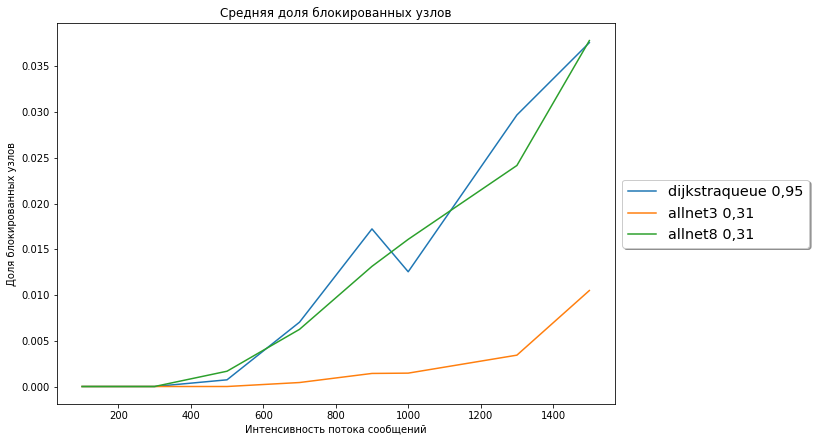

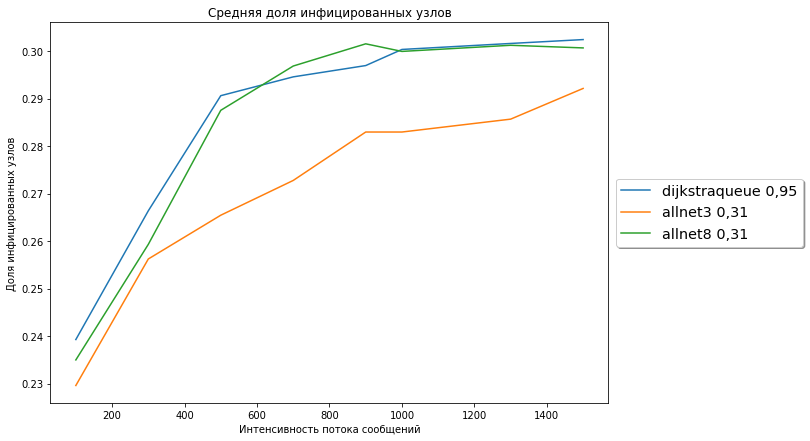

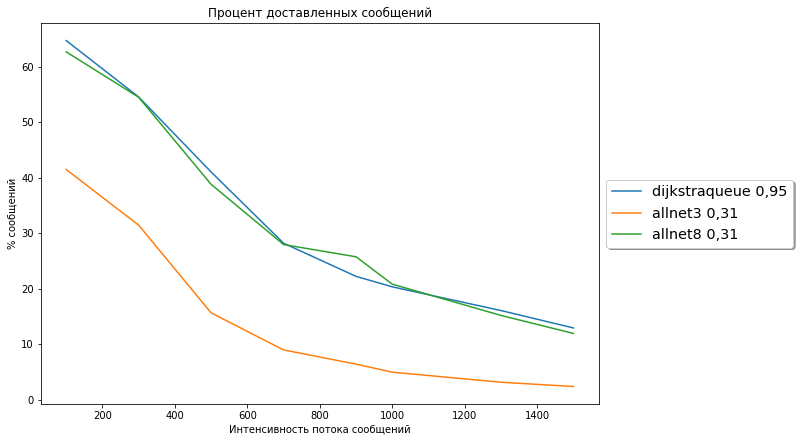

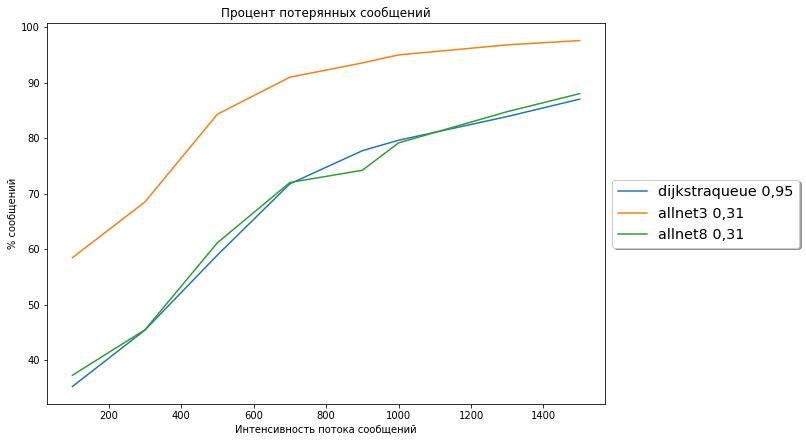

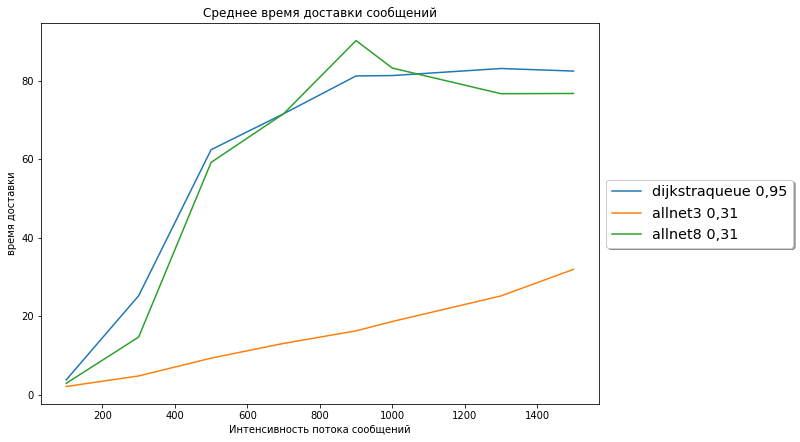

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.013104
allnet3 0,31          0.002156
allnet8 0,31          0.012392

dijkstraqueue 0,95    67.465595
allnet3 0,31          85.673010
allnet8 0,31          67.767531

dijkstraqueue 0,95    61.407783
allnet3 0,31          15.157081
allnet8 0,31          59.426044

dijkstraqueue 0,95    0.286505
allnet3 0,31          0.270957
allnet8 0,31          0.285239
